<a href="https://colab.research.google.com/github/kernelphan/ML-DL-Project/blob/main/Vietnamese_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
!pip install scikeras

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
warnings.filterwarnings('ignore')

# Underthesea - A Vietnamese NLP toolkit
!pip install underthesea > /dev/null 2>&1 # not print the pip installation
from underthesea import word_tokenize
from underthesea import text_normalize

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import wordcloud
import regex as re
import string
import random
import nltk
from datasets import load_dataset
from inspect import signature

# TensorFlow
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from scikeras.wrappers import KerasClassifier

# scikit-learn
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
dataset = load_dataset("uit-nlp/vietnamese_students_feedback") # https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8573337

train_df = dataset['train'].to_pandas()
val_df = dataset['validation'].to_pandas()
test_df = dataset['test'].to_pandas()

# Concatenate all DataFrames into one (so data is more objective and balance)
df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# Randomly mix/shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)
df.rename(columns = {'sentence': 'content', 'sentiment': 'label'}, inplace = True)

README.md:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

vietnamese_students_feedback.py:   0%|          | 0.00/4.97k [00:00<?, ?B/s]

The repository for uit-nlp/vietnamese_students_feedback contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/uit-nlp/vietnamese_students_feedback.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
print('Dataset columns, rows:', df.shape)
print('How many labels and their counts?:', df['label'].value_counts())
print('How many kind of topic and their counts?:', df['topic'].value_counts())

Dataset columns, rows: (16175, 3)
How many labels and their counts?: label
2    8038
0    7439
1     698
Name: count, dtype: int64
How many kind of topic and their counts?: topic
0    11607
1     3040
3      816
2      712
Name: count, dtype: int64


In [ ]:
df = df.drop_duplicates("content") # drop duplicates
df = df.dropna() # drop null
print('How many label and their count left?:', df['label'].value_counts())

How many label and their count left?: label
2    8037
0    7439
1     698
Name: count, dtype: int64


In [ ]:
emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"
                u"\U0001F300-\U0001F5FF"
                u"\U0001F680-\U0001F6FF"
                u"\U0001F1E0-\U0001F1FF"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE) # Unicode emojis.

def clean_text(text):
    text = text.lower() # lowercase text

    text = re.sub(emoji_pattern, " ", text) # remove emojis

    text = re.sub(r'([a-z]+?)\1+',r'\1', text) # reduce repeated character (e.g. 'aaabbb' -> 'ab')

    # Ensure space before and after any punctuation mark
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])", r"\1 \2", text)

    text = re.sub(f"([{string.punctuation}])([{string.punctuation}])+",r"\1", text) # reduce consecutive punctuation

    # Remove any leading or trailing spaces, or leading or trailing punctuation marks from the text
    text = text.strip()
    while text.endswith(tuple(string.punctuation+string.whitespace)):
        text = text[:-1]
    while text.startswith(tuple(string.punctuation+string.whitespace)):
        text = text[1:]

    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuation

    text = re.sub(r"\s+", " ", text) # reduce multiple spaces

    text = text_normalize(text) # make sure punctunation is in the right letter (Vietnamese case)
    text = word_tokenize(text, format="text") # tokenize the cleaned text
    # text = unidecode(text) # remove accent marks from sentences (no significant difference when accent marks is removed or kept)

    '''
    Proper tokenization allows models or algorithms to understand the semantics of the text better.
    For instance, `"đi chơi" (go play)` should be treated as one unit
    instead of two separate words "đi" (go) and "chơi" (play) for proper semantic understanding.
    '''
    return text

In [ ]:
df['corpus'] = df['content'].map(lambda text: clean_text(text))
# Final check
df.head(20)

,content,label,topic,corpus
0,mong muốn giảng viên nào cũng áp dụng như vậy ...,0,0,mong_muốn giảng_viên nào cũng áp_dụng như_vậy ...
1,"đừng để sinh viên ngủ , vắng khi đi học .",0,0,đừng để sinh_viên ngủ vắng khi đi học
2,"giảng viên nhiệt tình , phương pháp giảng dạy ...",2,0,giảng_viên nhiệt_tình phương_pháp giảng_dạy dễ...
3,ví dụ đề tài của em là doubledot các nguyên lý...,1,3,ví_dụ đề_tài của em là doubledot các nguyên_lý...
4,cô giải thích các vấn đề sinh viên đưa ra khá ...,2,0,cô giải_thích các vấn_đề sinh_viên đưa ra khá ...
5,"thầy giảng buồn ngủ , không nhiệt tình , bài t...",0,0,thầy giảng buồn_ngủ không nhiệt_tình bài_tập t...
6,góp ý cho thầy .,1,0,góp_ý cho thầy
7,cách giảng dạy của thầy rất tuyệt vời rất sát ...,2,0,cách giảng_dạy của thầy rất tuyệt_vời rất sát ...
8,"tiết học còn nhàm chán , chưa tạo được hứng thú .",0,0,tiết học còn nhàm_chán chưa tạo được hứng_thú
9,"thầy dạy nhiệt tình , cám ơn thầy .",2,0,thầy dạy nhiệt_tình cám_ơn thầy


Number of words: 16001
Most common words: [('thầy dạy hay dễ hiểu', 4), ('nhiệt_tình tâm_huyết', 3), ('giảng_viên nhiệt_tình tận_tâm', 3), ('nhiệt_tình vui_tính', 3), ('giảng_viên tận_tâm nhiệt_tình', 3), ('thầy dạy nhiệt_tình tận_tâm', 3), ('em cảm_ơn', 3), ('giảng_viên dạy nhiệt_tình dễ hiểu', 3), ('giáo_viên tận_tâm nhiệt_tình', 2), ('giảng_viên nhiệt_tình vui_vẻ', 2), ('giảng_viên tận_tâm nhiệt_tình vui_vẻ', 2), ('thầy nhiệt_tình dễ_thương', 2), ('giảng bài hay', 2), ('slide bài giảng đầy_đủ rõ_ràng giáo_viên đúng giờ', 2), ('nhiệt_tình thân_thiện', 2)]


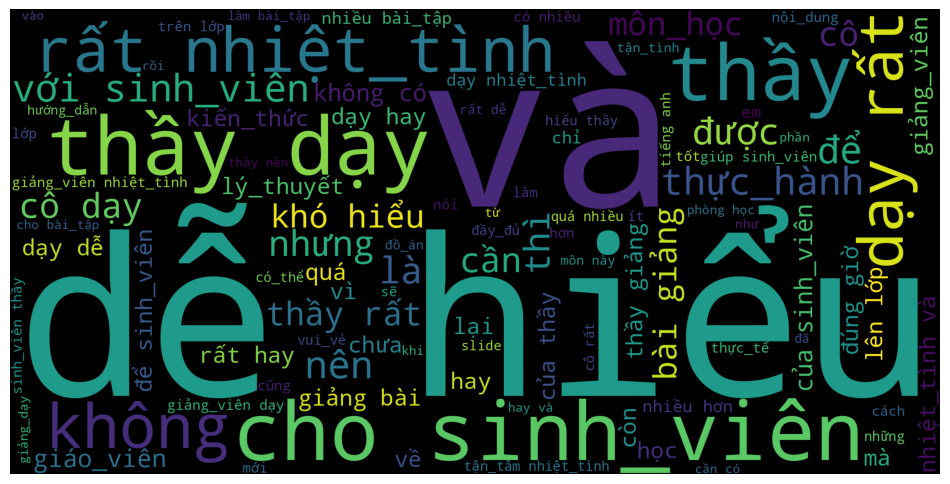

In [ ]:
# Create bag-of-words
all_words = [token for token in df['corpus'].tolist() if token and token != '']

corpus=' '.join(all_words)
all_words = nltk.FreqDist(all_words)

# Print the total number of words and the 15 most common words
print('Number of words: {}'.format(len(all_words)))
print('Most common words: {}'.format(all_words.most_common(15)))

plt.figure(figsize=(12,8))
word_cloud = wordcloud.WordCloud(max_words=100,background_color ="black",
                               width=2000,height=1000,mode="RGB").generate(corpus)
plt.axis("off")
plt.imshow(word_cloud)

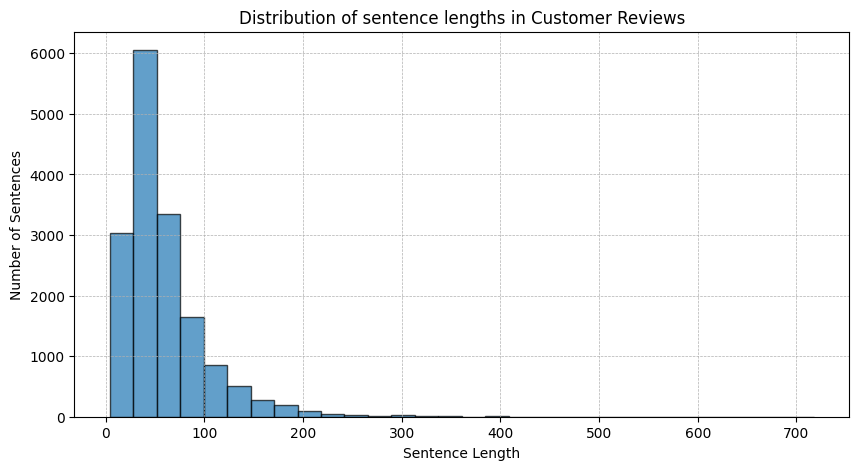

In [ ]:
# Calculate the length of each sentence directly
lengths = df['content'].apply(len)

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(lengths, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of sentence lengths in Customer Reviews')
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

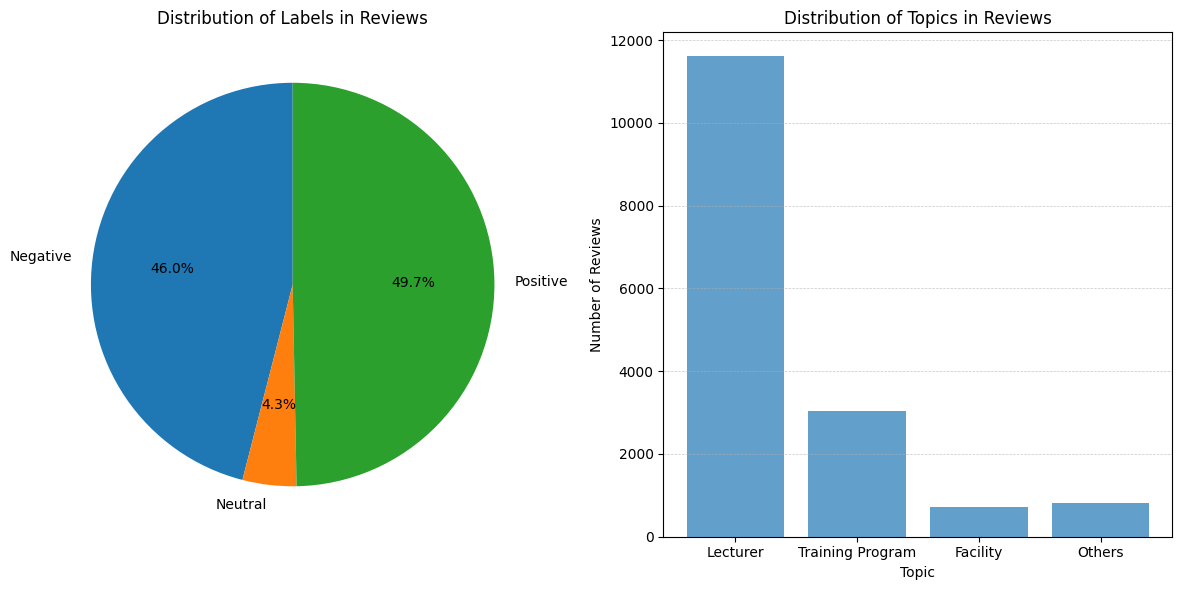

In [ ]:
# Count the occurrences of each label and topic
label_counts = df['label'].value_counts().sort_index()
topic_counts = df['topic'].value_counts().sort_index()

# Set up the figure and axis
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for labels
labels = ['Negative', 'Neutral', 'Positive']  # updated labels
ax[0].pie(label_counts, labels=labels, autopct='%1.1f%%', startangle=90)
ax[0].set_title('Distribution of Labels in Reviews')

# Bar chart for topics
topics = ['Lecturer', 'Training Program', 'Facility', 'Others']  # updated topics
ax[1].bar(topics, topic_counts, alpha=0.7)
ax[1].set_title('Distribution of Topics in Reviews')
ax[1].set_xlabel('Topic')
ax[1].set_ylabel('Number of Reviews')
ax[1].grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# First, split the data into 80% training and 20% temporary testing.
train_sentences, test_sentences, train_labels, test_labels = train_test_split(
    df['corpus'],
    df['label'],
    test_size=0.1,
    stratify=df['topic'],
    random_state=42
)

In [ ]:
from sklearn.utils import resample

# Separate neutral comments
neutral_indices = np.where(train_labels == 1)[0]
oversample_size = len(train_labels[train_labels == 0]) - len(neutral_indices)

# Over-sample the neutral comments
oversampled_neutral_indices = resample(neutral_indices,
                                       replace=True,
                                       n_samples=oversample_size)

# Combine the original sentences and labels with the oversampled data
oversampled_neutral_sentences = np.array(train_sentences)[oversampled_neutral_indices]

train_sentences_oversampled = np.concatenate([train_sentences, oversampled_neutral_sentences], axis=0)
train_labels_oversampled = np.concatenate([train_labels, np.array([1] * oversample_size)], axis=0)

In [ ]:
oversampled_neutral_sentences = np.array(train_sentences)[oversampled_neutral_indices]

train_sentences_oversampled = np.concatenate([train_sentences, oversampled_neutral_sentences], axis=0)
train_labels_oversampled = pd.Series(train_labels_oversampled)

In [ ]:
# Count occurrences of each label in train_labels_oversampled
unique_labels, counts = np.unique(train_labels_oversampled, return_counts=True)

# Display the distribution
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count}")

Label 0: 6676
Label 1: 6676
Label 2: 7253


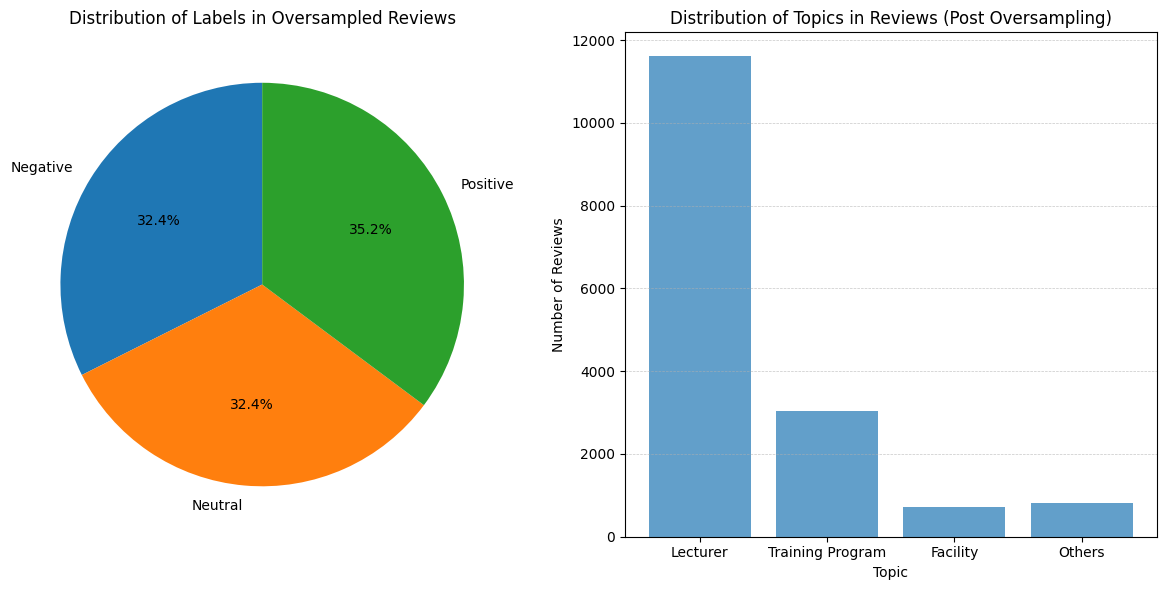

In [ ]:
# First, you need to create a new DataFrame or series for your oversampled data
# For this example, let's assume your oversampled DataFrame is `df_oversampled`

# Update the label counts based on the oversampled data
label_counts_oversampled = pd.Series(train_labels_oversampled).value_counts().sort_index()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for labels after over-sampling
labels = ['Negative', 'Neutral', 'Positive']
ax[0].pie(label_counts_oversampled, labels=labels, autopct='%1.1f%%', startangle=90)
ax[0].set_title('Distribution of Labels in Oversampled Reviews')

# Bar chart for topics (assuming they were oversampled too)
topics = ['Lecturer', 'Training Program', 'Facility', 'Others']
ax[1].bar(topics, topic_counts, alpha=0.7)
ax[1].set_title('Distribution of Topics in Reviews (Post Oversampling)')
ax[1].set_xlabel('Topic')
ax[1].set_ylabel('Number of Reviews')
ax[1].grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Fit the vectorizer on the training data only
vectorizer.fit(train_sentences)

CountVectorizer()

In [ ]:
sample_sentences = df['corpus'].head(5).tolist() # select a sample of sentences
sample_transformed = vectorizer.transform(sample_sentences) # transform the sample sentences

sample_array = sample_transformed.toarray() # convert the transformed data

# Print results for each sentence in the sample
for idx, sentence in enumerate(sample_sentences):
    print(f"Sentence: {sentence}")
    print("Token : Count")
    for token, count in zip(vectorizer.get_feature_names_out(), sample_array[idx]):
        if count > 0:
            print(f"{token} : {count}")
    print("------\n")

Sentence: mong_muốn giảng_viên nào cũng áp_dụng như_vậy thì quá tốt
Token : Count
cũng : 1
giảng_viên : 1
mong_muốn : 1
như_vậy : 1
nào : 1
quá : 1
thì : 1
tốt : 1
áp_dụng : 1
------

Sentence: đừng để sinh_viên ngủ vắng khi đi học
Token : Count
học : 1
khi : 1
ngủ : 1
sinh_viên : 1
vắng : 1
đi : 1
để : 1
đừng : 1
------

Sentence: giảng_viên nhiệt_tình phương_pháp giảng_dạy dễ hiểu
Token : Count
dễ : 1
giảng_dạy : 1
giảng_viên : 1
hiểu : 1
nhiệt_tình : 1
phương_pháp : 1
------

Sentence: ví_dụ đề_tài của em là doubledot các nguyên_lý cơ_bản bao_gồm 7 nguyên_tắc của bohm 1983
Token : Count
1983 : 1
bao_gồm : 1
bohm : 1
các : 1
cơ_bản : 1
của : 2
doubledot : 1
em : 1
là : 1
nguyên_lý : 1
nguyên_tắc : 1
ví_dụ : 1
đề_tài : 1
------

Sentence: cô giải_thích các vấn_đề sinh_viên đưa ra khá chi_tiết
Token : Count
chi_tiết : 1
các : 1
cô : 1
giải_thích : 1
khá : 1
ra : 1
sinh_viên : 1
vấn_đề : 1
đưa : 1
------



In [ ]:
# Convert the entire oversampled sentences into the Bag-of-Words representation
X_oversampled_bow = vectorizer.transform(train_sentences_oversampled)
y_oversampled_bow = train_labels_oversampled

In [ ]:
MAX_VOCAB_LENGTH = 20000

sequence_lengths = [len(sentence.split()) for sentence in train_sentences] # Calculate the length of each sentence in the training data
MAX_LENGTH = int(np.percentile(sequence_lengths, 95)) # Set MAX_LENGTH as the 95th percentile of the sequence lengths

In [ ]:
text_vectorizer = TextVectorization(max_tokens=MAX_VOCAB_LENGTH, # Maximum size of the vocabulary for this layer
                                    standardize="lower_and_strip_punctuation", # Text will be lowercased and all punctuation removed
                                    split="whitespace", # Split on whitespace
                                    ngrams=None,
                                    output_mode="int", # Outputs integer indices, one integer index per split string token
                                    output_sequence_length=MAX_LENGTH) # the output will have its time dimension padded or truncated to exactly output_sequence_length values

text_vectorizer.adapt(train_sentences) # Computes a vocabulary of string terms from tokens in a dataset.

In [ ]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # ([UNK] token is unknown words)
bottom_5_words = words_in_vocab[-5:]
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # ([UNK] token is unknown words)
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")


Number of words in vocab: 4579
Top 5 most common words: ['', '[UNK]', 'thầy', 'sinhviên', 'dạy']
Bottom 5 least common words: ['200', '1983', '19', '140', '14']


In [ ]:
def create_embedding_layer(input_dim=MAX_VOCAB_LENGTH, output_dim=128, embeddings_initializer="uniform", input_length=MAX_LENGTH, name=None):
    """
    Create an Embedding layer for use in a deep learning model.

    Parameters:
    - input_dim (int): Size of the input vocabulary.
    - output_dim (int, optional): Dimension of the dense embedding. Defaults to 128.
    - embeddings_initializer (str or keras.initializers, optional): Initializer for the embeddings matrix. Defaults to "uniform".
    - input_length (int, optional): Length of input sequences, when it is constant.
    - name (str, optional): Name of the layer. Defaults to None.

    Returns:
    - TensorFlow/Keras Embedding layer.
    """
    return layers.Embedding(
        input_dim=input_dim,
        output_dim=output_dim,
        embeddings_initializer=embeddings_initializer,
        input_length=input_length,
        name=name
    )

In [ ]:
def create_ml_model(model_type, **kwargs):
    '''
    Create Machine Learning model
    '''
    models = {
        'naive_bayes': MultinomialNB,
        'svm': LinearSVC,
        'random_forest': RandomForestClassifier,
        'logistic_regression': LogisticRegression,
        'ml_ensemble': lambda: create_ml_stacking_classifier(**kwargs)
    }

    # Retrieve the model class based on the model_type argument
    model = models.get(model_type.lower())

    # Check if the model type exists
    if model:
        return model(**kwargs)
    else:
        supported_models = ", ".join(models.keys())
        print(f"Error: Model type '{model_type}' is not supported.\n"
              f"Supported models are: {supported_models}.\n"
              f"Please add your perferred model to create_model function.")
        return None

In [ ]:
def kfold_evaluation(model, X, y, kfold):
    '''
    1. Train ML model on KFold

    2. Return metrics for each KFold and all KFolds
    '''
    fold_results = [] # average validation data results on all Kfolds
    fold_result_each_kfold = [] # training and validation results on each Kfold

    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Train the model
        model.fit(X_train, y_train)

        # Predict on both sets
        train_predictions = model.predict(X_train)
        val_predictions = model.predict(X_val)

        # Calculate metrics for both sets
        train_metrics = calculate_results(y_train, train_predictions)
        val_metrics = calculate_results(y_val, val_predictions)

        fold_result = {
            'fold': len(fold_results) + 1,
            'train_metrics': train_metrics,
            'validation_metrics': val_metrics
        }

        fold_results.append(val_metrics)
        fold_result_each_kfold.append(fold_result)

    # Compute the average metrics over all folds
    model_results = {
        "accuracy": np.mean([result["accuracy"] for result in fold_results]),
        "precision": np.mean([result["precision"] for result in fold_results]),
        "recall": np.mean([result["recall"] for result in fold_results]),
        "f1": np.mean([result["f1"] for result in fold_results])
    }

    # Retrain the model on the entire dataset
    model.fit(X, y)

    return model, fold_result_each_kfold, model_results

In [ ]:
def calculate_results(y_true, y_pred):
    '''
    Calculate accuracy, precision, recall, f1 score for a model
    '''
    model_accuracy = accuracy_score(y_true, y_pred) * 100  # Scale to 1-100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    model_results = {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1": model_f1
    }

    return model_results

In [ ]:
def compare_baseline_to_new_results(baseline_results, new_model_results, baseline_name='Baseline', new_model_name='New Model'):
    '''
    Compare baseline and new model results on metrics and plot the results using a line graph.
    '''
    metrics = list(baseline_results.keys())
    baseline_scores = [baseline_results[metric] * 100 if metric != 'accuracy' else baseline_results[metric] for metric in metrics]
    new_model_scores = [new_model_results[metric] * 100 if metric != 'accuracy' else new_model_results[metric] for metric in metrics]

    # Textual comparison
    # for key, value in baseline_results.items():
        # print(f"{baseline_name} {key}: {value:.2f}, {new_model_name} {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

    # Set up the seaborn style and palette
    sns.set(style="whitegrid", palette="muted")
    colors = ["#3498db", "#e74c3c"]  # Blue for baseline, Red for new model

    # Plotting
    x = np.arange(len(metrics))
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(x, baseline_scores, label=baseline_name, marker='o', markersize=6, linewidth=2, color=colors[0])
    ax.plot(x, new_model_scores, label=new_model_name, marker='s', markersize=6, linewidth=2, color=colors[1])

    # Adjust y-axis range
    max_score = max(max(baseline_scores), max(new_model_scores))
    min_score = min(min(baseline_scores), min(new_model_scores))
    ax.set_ylim([min_score - 1, max_score + 1])  # Add padding to the top and bottom
    ax.set_facecolor('#f8f9fa')  # Light gray background

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores (%)')
    ax.set_title(f'Performance Comparison: {baseline_name} vs {new_model_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Attach a text label at each marker, displaying its height with increased vertical offset
    label_offset = 0.25  # Increased vertical offset for the labels
    for i in range(len(metrics)):
        ax.text(x[i], baseline_scores[i] + label_offset, f'{baseline_scores[i]:.2f}%', ha='center', va='bottom')
        ax.text(x[i], new_model_scores[i] + label_offset, f'{new_model_scores[i]:.2f}%', ha='center', va='bottom')

    fig.tight_layout()
    plt.show()

In [ ]:
def format_metrics_compact(metrics):
    '''
    Helper function to format metrics compactly
    '''
    return ", ".join([f"{key.capitalize()}: {value:.2f}" for key, value in metrics.items()])

def display_all_folds_results(model_name, model_results):
    '''
    Print average metrics of validation data on all KFolds
    '''
    print(f"Average {model_name} Performance Metrics Across All Folds (on validation data):")
    print(f"- Accuracy: {model_results['accuracy']:.2f}%")
    print(f"- Precision: {model_results['precision']:.4f}")
    print(f"- Recall: {model_results['recall']:.4f}")
    print(f"- F1 Score: {model_results['f1']:.4f}")

In [ ]:
def display_each_fold_result(model_name, fold_results):
    '''
    Print metrics of training and validation data on each KFold and plot the accuracy graph using Seaborn.
    '''
    # Set up the seaborn style and palette
    sns.set(style="whitegrid", palette="muted")
    colors = ["#3498db", "#e74c3c"]  # Blue for Training, Red for Validation

    # Header
    print(f"{model_name} Performance Metrics Across Each Fold (on training and validation data):")
    print()
    print(f"{'Fold':<5} | {'Training Metrics':<70} | {'Validation Metrics':<70}")
    print("-" * 150)

    # Prepare data for plotting
    train_accuracies = []
    val_accuracies = []
    folds = []

    # Display results for each fold and collect data for graph
    for result in fold_results:
        train_metrics_formatted = format_metrics_compact(result['train_metrics'])
        val_metrics_formatted = format_metrics_compact(result['validation_metrics'])
        print(f"{result['fold']:<5} | {train_metrics_formatted:<70} | {val_metrics_formatted:<70}")

        # Append data for graph
        folds.append(result['fold'])
        train_accuracies.append(result['train_metrics']['accuracy'])
        val_accuracies.append(result['validation_metrics']['accuracy'])

    # Plotting the accuracies using Seaborn
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.lineplot(x=folds, y=train_accuracies, label='Training Accuracy', marker='o', color=colors[0])
    sns.lineplot(x=folds, y=val_accuracies, label='Validation Accuracy', marker='o', color=colors[1])
    ax.set_facecolor('#f8f9fa')  # Light gray background

    # Adding percentages on markers
    label_offset = 0.25  # Increased vertical offset for the labels
    for i, (tr_acc, val_acc) in enumerate(zip(train_accuracies, val_accuracies)):
        ax.text(folds[i], tr_acc + label_offset, f"{tr_acc:.2f}%", ha='center', va='bottom')
        ax.text(folds[i], val_acc + label_offset, f"{val_acc:.2f}%", ha='center', va='bottom')

    plt.title(f"{model_name} model: Training vs Validation Accuracy per Fold")
    plt.xlabel('Fold')
    plt.ylabel('Accuracy (%)')
    plt.xticks(folds)
    plt.legend()
    ax.margins(y=0.2)  # Add 10% padding to the top and bottom
    fig.tight_layout()
    plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True)

In [ ]:
lr_model = create_ml_model('logistic_regression', max_iter=5000, solver='saga', multi_class='multinomial') # Set for multi-class classification

In [ ]:
lr_model, lr_each_fold_results, lr_results = kfold_evaluation(lr_model, X_oversampled_bow, y_oversampled_bow, skf)

In [ ]:
display_all_folds_results("Logistic Regression", lr_results)


Average Logistic Regression Performance Metrics Across All Folds (on validation data):
- Accuracy: 89.68%
- Precision: 0.9001
- Recall: 0.8968
- F1 Score: 0.8966


Logistic Regression Performance Metrics Across Each Fold (on training and validation data):

Fold  | Training Metrics                                                       | Validation Metrics                                                    
------------------------------------------------------------------------------------------------------------------------------------------------------
1     | Accuracy: 93.64, Precision: 0.94, Recall: 0.94, F1: 0.94               | Accuracy: 89.57, Precision: 0.90, Recall: 0.90, F1: 0.90              
2     | Accuracy: 93.60, Precision: 0.94, Recall: 0.94, F1: 0.94               | Accuracy: 89.93, Precision: 0.90, Recall: 0.90, F1: 0.90              
3     | Accuracy: 93.70, Precision: 0.94, Recall: 0.94, F1: 0.94               | Accuracy: 89.18, Precision: 0.90, Recall: 0.89, F1: 0.89              
4     | Accuracy: 93.75, Precision: 0.94, Recall: 0.94, F1: 0.94               | Accuracy: 90.15, Precision: 0.90, Recall: 0.90, F1: 0.90           

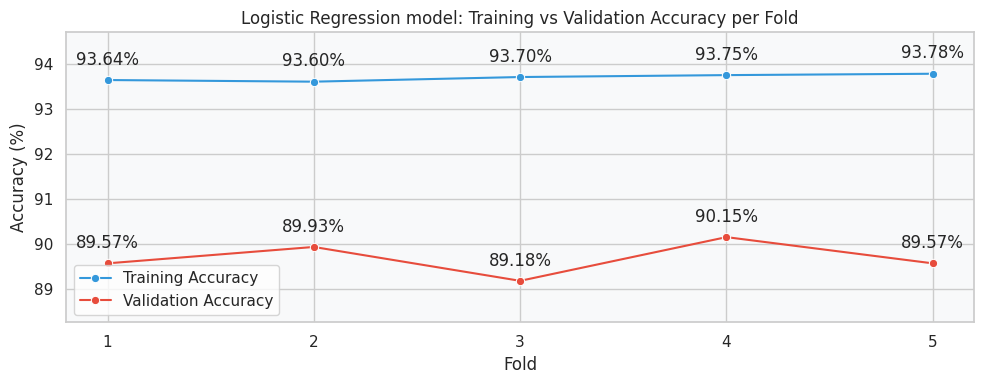

In [ ]:
display_each_fold_result("Logistic Regression",lr_each_fold_results)

In [ ]:
svm_model= create_ml_model('svm', max_iter=5000)

In [ ]:
svm_model, svm_each_fold_results, svm_results = kfold_evaluation(svm_model, X_oversampled_bow, y_oversampled_bow, skf)

In [ ]:
display_all_folds_results("SVM", svm_results)


Average SVM Performance Metrics Across All Folds (on validation data):
- Accuracy: 90.32%
- Precision: 0.9058
- Recall: 0.9032
- F1 Score: 0.9028


SVM Performance Metrics Across Each Fold (on training and validation data):

Fold  | Training Metrics                                                       | Validation Metrics                                                    
------------------------------------------------------------------------------------------------------------------------------------------------------
1     | Accuracy: 95.77, Precision: 0.96, Recall: 0.96, F1: 0.96               | Accuracy: 90.20, Precision: 0.90, Recall: 0.90, F1: 0.90              
2     | Accuracy: 95.67, Precision: 0.96, Recall: 0.96, F1: 0.96               | Accuracy: 90.56, Precision: 0.91, Recall: 0.91, F1: 0.91              
3     | Accuracy: 95.55, Precision: 0.96, Recall: 0.96, F1: 0.96               | Accuracy: 90.63, Precision: 0.91, Recall: 0.91, F1: 0.91              
4     | Accuracy: 95.59, Precision: 0.96, Recall: 0.96, F1: 0.96               | Accuracy: 90.39, Precision: 0.91, Recall: 0.90, F1: 0.90              
5     | Accu

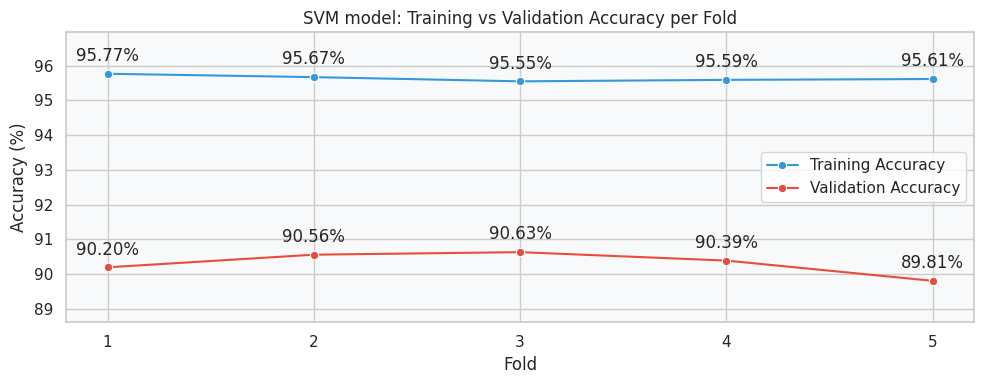

In [ ]:
display_each_fold_result("SVM",svm_each_fold_results)


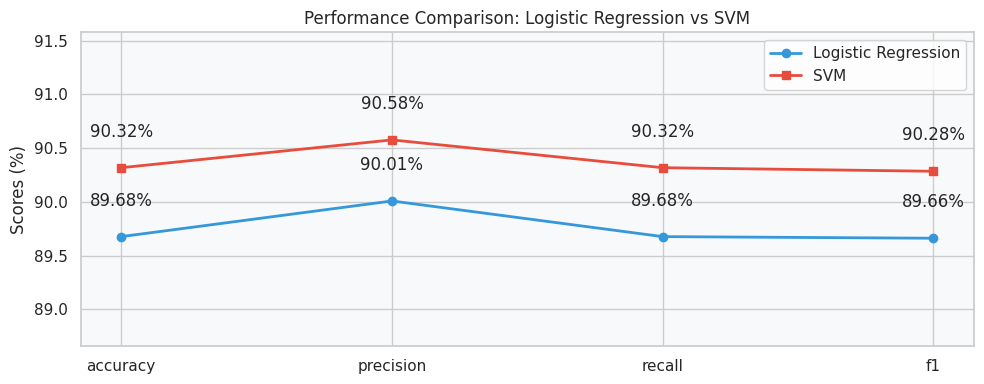

In [ ]:
# Compare Model 1: Support Vector Machines model with Model 0: Logistic Regression
compare_baseline_to_new_results(baseline_results=lr_results,
                                new_model_results=svm_results,
                                baseline_name='Logistic Regression', new_model_name='SVM')

In [ ]:
rf_model= create_ml_model('random_forest', n_estimators=100)


In [ ]:
rf_model, rf_each_fold_results, rf_results = kfold_evaluation(rf_model, X_oversampled_bow, y_oversampled_bow, skf)


In [ ]:
display_all_folds_results("Random Forest", rf_results)


Average Random Forest Performance Metrics Across All Folds (on validation data):
- Accuracy: 93.48%
- Precision: 0.9349
- Recall: 0.9348
- F1 Score: 0.9342


Random Forest Performance Metrics Across Each Fold (on training and validation data):

Fold  | Training Metrics                                                       | Validation Metrics                                                    
------------------------------------------------------------------------------------------------------------------------------------------------------
1     | Accuracy: 99.99, Precision: 1.00, Recall: 1.00, F1: 1.00               | Accuracy: 93.59, Precision: 0.94, Recall: 0.94, F1: 0.94              
2     | Accuracy: 99.98, Precision: 1.00, Recall: 1.00, F1: 1.00               | Accuracy: 93.04, Precision: 0.93, Recall: 0.93, F1: 0.93              
3     | Accuracy: 99.97, Precision: 1.00, Recall: 1.00, F1: 1.00               | Accuracy: 93.79, Precision: 0.94, Recall: 0.94, F1: 0.94              
4     | Accuracy: 99.98, Precision: 1.00, Recall: 1.00, F1: 1.00               | Accuracy: 93.30, Precision: 0.93, Recall: 0.93, F1: 0.93              
5 

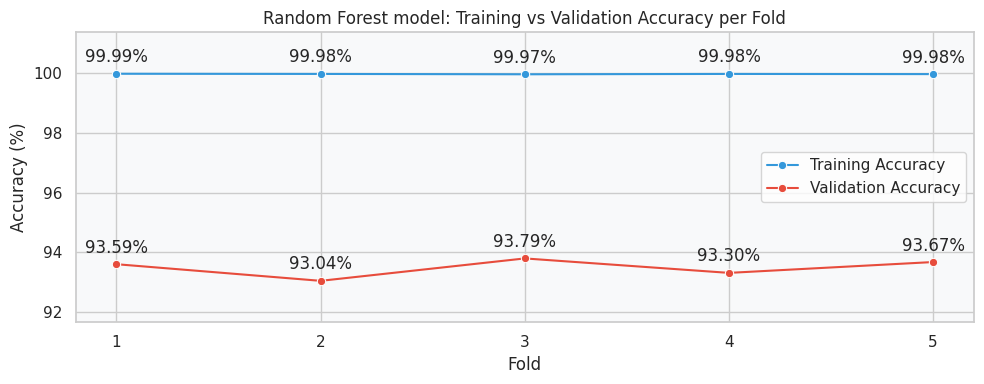

In [ ]:
display_each_fold_result("Random Forest",rf_each_fold_results)


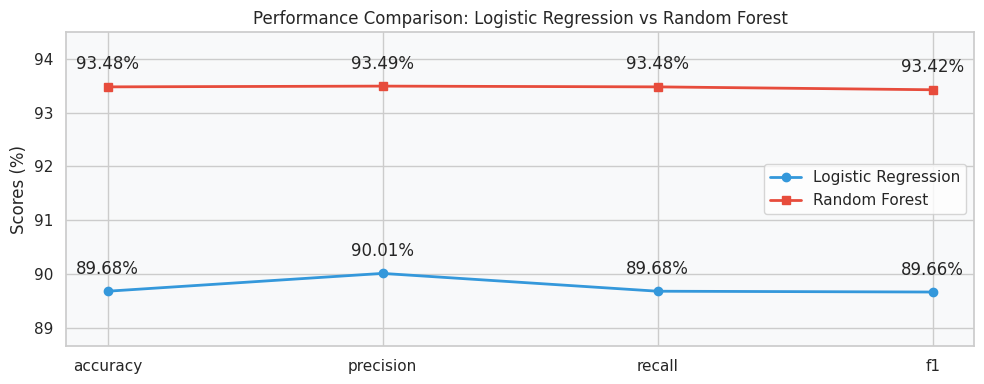

In [ ]:
# Compare Model 2: Random Forest model with Model 0: Logistic Regression
compare_baseline_to_new_results(baseline_results=lr_results,
                                new_model_results=rf_results,
                                baseline_name='Logistic Regression', new_model_name='Random Forest')

In [ ]:
def create_ml_stacking_classifier(**kwargs):
    svm_model = make_pipeline(MaxAbsScaler(), LinearSVC(max_iter=10000))
    rf_model = RandomForestClassifier(n_estimators=100)
    lr_model = LogisticRegression(max_iter=10000, solver='saga', multi_class='multinomial')

    estimators = kwargs.get('estimators', [
        ('svm', svm_model),
        # ('rf', rf_model),
        ('lr', lr_model)
    ])
    final_estimator = kwargs.get('final_estimators', LogisticRegression(max_iter=10000, solver='saga'))

    return StackingClassifier(estimators, final_estimator)

In [ ]:
ml_ensemble_model = create_ml_model('ml_ensemble')


In [ ]:
ml_ensemble_model, ml_ensemble_each_fold_results, ml_ensemble_results = kfold_evaluation(ml_ensemble_model, X_oversampled_bow, y_oversampled_bow, skf)


In [ ]:
display_all_folds_results("Machine Learning Ensemble", ml_ensemble_results)


Average Machine Learning Ensemble Performance Metrics Across All Folds (on validation data):
- Accuracy: 90.44%
- Precision: 0.9055
- Recall: 0.9044
- F1 Score: 0.9042


Machine Learning Ensemble Performance Metrics Across Each Fold (on training and validation data):

Fold  | Training Metrics                                                       | Validation Metrics                                                    
------------------------------------------------------------------------------------------------------------------------------------------------------
1     | Accuracy: 94.86, Precision: 0.95, Recall: 0.95, F1: 0.95               | Accuracy: 90.51, Precision: 0.91, Recall: 0.91, F1: 0.90              
2     | Accuracy: 94.93, Precision: 0.95, Recall: 0.95, F1: 0.95               | Accuracy: 90.08, Precision: 0.90, Recall: 0.90, F1: 0.90              
3     | Accuracy: 94.96, Precision: 0.95, Recall: 0.95, F1: 0.95               | Accuracy: 90.22, Precision: 0.90, Recall: 0.90, F1: 0.90              
4     | Accuracy: 94.67, Precision: 0.95, Recall: 0.95, F1: 0.95               | Accuracy: 90.44, Precision: 0.91, Recall: 0.90, F1: 0.90     

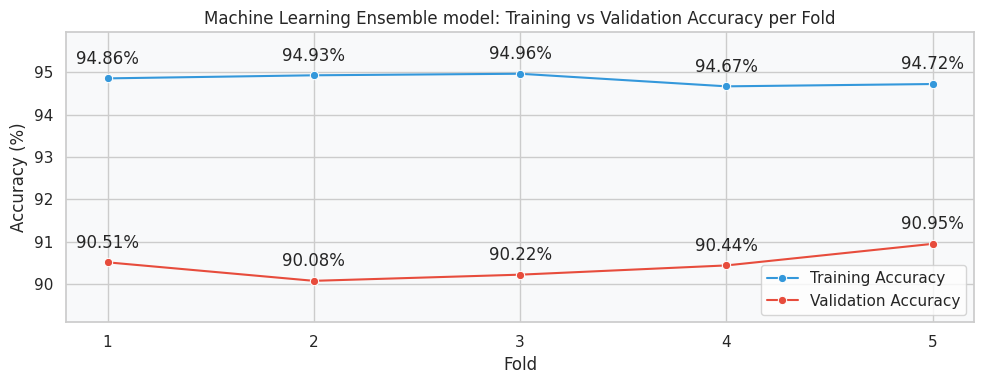

In [ ]:
display_each_fold_result("Machine Learning Ensemble", ml_ensemble_each_fold_results)


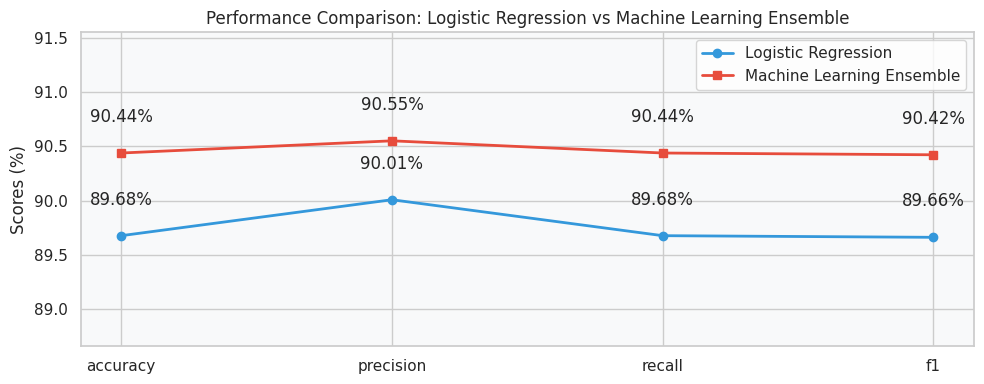

In [ ]:
# Compare Model 3: Machine Learning Emsemble model with Model 0: Logistic Regression model
compare_baseline_to_new_results(baseline_results=lr_results,
                                new_model_results=ml_ensemble_results,
                                baseline_name='Logistic Regression', new_model_name='Machine Learning Ensemble')

In [ ]:
# Default parameters
CV = ShuffleSplit(n_splits=2, test_size=0.1, random_state=42)
EPOCHS = 5
BATCH_SIZE = 32

In [ ]:
# Parameters for RandomizedSearchCV
param_dist = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'dense_units': [32, 64, 128],
    'dropout': [0.2, 0.3, 0.4, 0.5],
    'l1_reg': [0.001, 0.01, 0.1],
    'l2_reg': [0.001, 0.01, 0.1],
    'batch_normalization': [True, False],

    # options for convolutional layers
    'kernel_initializer': ["he_uniform", 'he_normal'],
    'padding': ['valid', 'same'],
}

In [ ]:
# Split the data into training and validation sets (for deep learning model)
X_train, X_val, y_train, y_val = train_test_split(
    train_sentences_oversampled,
    train_labels_oversampled,
    test_size=0.1,  # 10% of the data will be used for validation
    random_state=42
)

In [ ]:
def filter_param_dist_for_model(model_creation_fn, param_dist=param_dist):
    """
    Filter the parameter distribution dictionary to only include keys that are
    valid parameters for the given model creation function.

    Parameters:
    - param_dist: Original full parameter distribution dictionary.
    - model_creation_fn: Function used to create the model.

    Returns:
    - Filtered parameter distribution dictionary.
    """
    # Inspect the signature of the model creation function
    valid_params = signature(model_creation_fn).parameters.keys()

    # Filter the param_dist dictionary
    filtered_param_dist = {key: value for key, value in param_dist.items() if key in valid_params}

    return filtered_param_dist

In [ ]:
def perform_random_search(model_creation_fn, model_name, param_dist=param_dist, X_train=X_train, y_train=y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, n_iter=3, cv=skf):
    """
    Perform Randomized Search for hyperparameter tuning on a deep learning model.
    """

    # Define the parameter distribution including epochs and batch_size,
    param_dist = {
        'epochs': [3, 5],
        'batch_size': [16, 32, 64],
        **(filter_param_dist_for_model(model_creation_fn)) # output is param_dist that have only keys that model_creation_fn has
    }

    # Wrap the model creation function with KerasClassifier
    keras_model = KerasClassifier(build_fn=model_creation_fn, epochs=epochs, batch_size=batch_size, verbose=0)

    # Set up RandomizedSearchCV
    randomized_search = RandomizedSearchCV(estimator=keras_model, param_distributions=param_dist, n_iter=n_iter, cv=cv, verbose=0)

    # Fit the RandomizedSearchCV to find the best parameters
    randomized_search.fit(X_train, y_train)

    # Display results
    print(f"\n{model_name} Model Results After Hyperparameter Tuning:\n")

    # Get all the results from the randomized search
    cv_results = randomized_search.cv_results_
    for params, mean_test_score, rank in zip(cv_results["params"], cv_results["mean_test_score"], cv_results["rank_test_score"]):
        print(f"Params: {params} - Mean Test Score: {mean_test_score:.2f} - Rank: {rank}")

    # Get the best parameters
    best_parameters = randomized_search.best_params_
    print(f"\nBest Parameters from {model_name} model: {best_parameters}\n")

    # Retrieve the best model after search
    best_model = randomized_search.best_estimator_.model

    return best_model

In [ ]:
def display_dl_results(best_model, model_name, X_val=X_val, y_val=y_val):
    """
    Display results of a deep learning model after hyperparameter tuning and evaluate on validation data.
    """
    # Display the best model's summary
    best_model.summary()

    # Predict on the validation set using the best model
    pred_probs = best_model.predict(X_val, verbose=0)
    class_preds = np.argmax(pred_probs, axis=1)

    # Calculate and display results (accuracy, precision, recall, and f1 score)
    results = calculate_results(y_true=y_val, y_pred=class_preds)
    print(f"\n{model_name} Validation Data Results:")
    for metric, score in results.items():
        print(f"- {metric.capitalize()}: {score:.2f}")

    return results

In [ ]:
def create_fc_model(learning_rate=0.001, dense_units=32, dropout=0.5, l2_reg=0.01, activation='relu'):
    inputs = layers.Input(shape=(1, ), dtype="string")
    x = text_vectorizer(inputs)
    x = create_embedding_layer(name='base_dense_embedding')(x)

    # Flatten the embeddings
    x = layers.Flatten()(x)

    # Add fully connected (Dense) layers with dropout
    x = layers.Dense(dense_units*2, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(dense_units, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(3, activation="softmax")(x)

    model = Model(inputs, outputs, name="fully_connected_layers_model")
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])
    return model

In [ ]:
fc_model = perform_random_search(create_fc_model, model_name='Fully Connected Layers')


ValueError: Invalid parameter learning_rate for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(learning_rate=0.001)`
Check the list of available parameters with `estimator.get_params().keys()`

In [ ]:
fc_model_results = display_dl_results(fc_model, model_name='Fully Connected Layers')

NameError: name 'fc_model' is not defined

In [ ]:
# Compare Model 1: Fully Connected Layer model with Model 0: Logistic Regression model
compare_baseline_to_new_results(baseline_results=lr_results,
                                new_model_results=fc_model_results,
                                baseline_name='Logistic Regression', new_model_name='Fully Connected Layers')

In [ ]:
def extract_embeddings(model, sentences):
    """
    Uses the provided model to extract embeddings for the given sentences.
    Assumes that the embedding layer is named "embedding_1".
    """
    # Predict using the given model to get the output before the final dense layer
    intermediate_output = model.predict(sentences)

    return intermediate_output

test_embeddings = extract_embeddings(create_fc_model(), test_sentences)